In [33]:
%load_ext autoreload
%autoreload 2

from importers import SpikeImporter

data_folder = "../data/"
file_name = "20_05_13_U1a_4960s_5400s"
file_ending = ".csv"

time_channel = "Time"
signal_channel = "1 Signal"
stimulus_channel = "32 DigMark"
ap_marker_channels = ["3 nw-1"]
extra_stimuli_channel = "801 DigMark"

# load the animal file
importer = SpikeImporter(filepath = data_folder + file_name + file_ending, time_channel = time_channel, signal_channel = signal_channel)

print("Data loaded.")

# define the max. time so that two sequential waveform-values are belonging to the same AP
# the time is in seconds, so 0.005 equals 5ms
max_gap_time = 0.005

# retrieve the events from the importer 
el_stimuli = importer.get_electrical_stimuli(regular_stimulus_channel = stimulus_channel)
el_extra_stimuli = importer.get_extra_stimuli(extra_stimulus_channel = extra_stimuli_channel, regular_el_stimuli = el_stimuli, verbose = False)
actpots = importer.get_action_potentials(max_gap_time = max_gap_time, ap_marker_channels = ap_marker_channels, \
                                      el_stimuli = el_stimuli, mech_stimuli = [], el_extra_stimuli = el_extra_stimuli, verbose = False)
raw_signal = importer.get_raw_signal_split_by_stimuli(el_stimuli = el_stimuli, verbose = False)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Data loaded.
List of eletrical stimuli created.
List of extra eletrical stimuli created.
Finished processing AP channel 1 out of 1
List of APs created.
Done with cropping the intervals


In [34]:
''' 
This cell performs the clustering according to
- distance to previous stimulus
- normalized signal energy of the APs
'''
%autoreload 2
from fibre_tracking import DBSCANClustering
from plotting import ClusterPlot2D

clustered_data_df = DBSCANClustering.perform_clustering(actpots, eps = 0.005, min_samples = 10, save_fibre_prediction = True)

cl2dplot = ClusterPlot2D()
cl2dplot.plot(clustered_data_df = clustered_data_df)

In [35]:
%autoreload 2
from plotting import FallingLeafPlot
from ipywidgets import interact_manual, interactive, fixed, IntSlider, FloatSlider

tmin, tmax = importer.get_time_range()
max_interval_length = max([stim.get_interval_length() for stim in el_stimuli])

flplot = FallingLeafPlot()
interact_manual(flplot.plot, regular_stimuli = fixed(el_stimuli), action_potentials = fixed(actpots), \
                t_start = FloatSlider(min = tmin, max = tmax, value = 0), \
                num_intervals = IntSlider(min = 1, max = 50, step = 1, value = 5), \
                post_stimulus_timeframe = FloatSlider(min = 0, max = max_interval_length, value = 0.1), \
                manual_name = "Update Plot")

interactive(children=(FloatSlider(value=0.0, description='t_start', max=440.0), IntSlider(value=5, description…

<function ipywidgets.widgets.interaction._InteractFactory.__call__.<locals>.<lambda>(*args, **kwargs)>

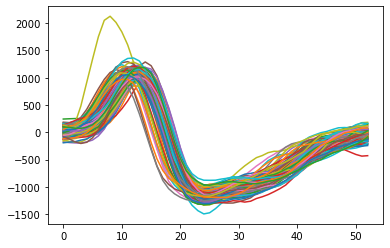

avg. len: 53 avg argmax: 13


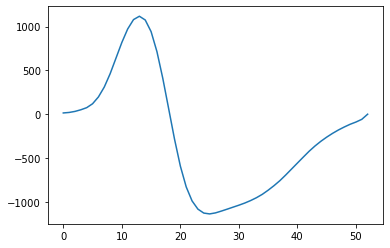

In [53]:
%autoreload 2
from fibre_tracking import ActionPotentialTemplate

# get the APs for a certain cluster number
cluster_idcs = [0]
filtered_aps = list(filter(lambda ap: ap.get_implied_fibre_index() in cluster_idcs, actpots))

ActionPotentialTemplate.from_ap_list(aps = filtered_aps)